<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_DWI_SE_EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.8/471.8 kB 7.2 MB/s eta 0:00:00


(DWI_SE_EPI_seq)=
# 2D DWI SE EPI

C:\Users\alyar\AppData\Local\Temp\ipykernel_21132\3980521511.py:41: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf90, gz90, gz90_re = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_21132\3980521511.py:46: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf180, gz180, gz180_re = pp.make_sinc_pulse(
C:\Users\alyar\github\MRzero-Core\python\MRzeroCore\phantom\voxel_grid_phantom.py:189: DeprecationWarning: brainweb() will be removed in a future version, use load() instead
  warn("brainweb() will be removed in a future version, use load() instead", DeprecationWarning)


TE_EPI =  0.04367
TE_Diffusion_temp =  0.01987
A delay of  0.0238  is necessary
Calculated b-value: 737.97 s/mm^2
Timing check passed successfully
VoxelGridPhantom
size = tensor([0.1920, 0.1920, 0.0800])


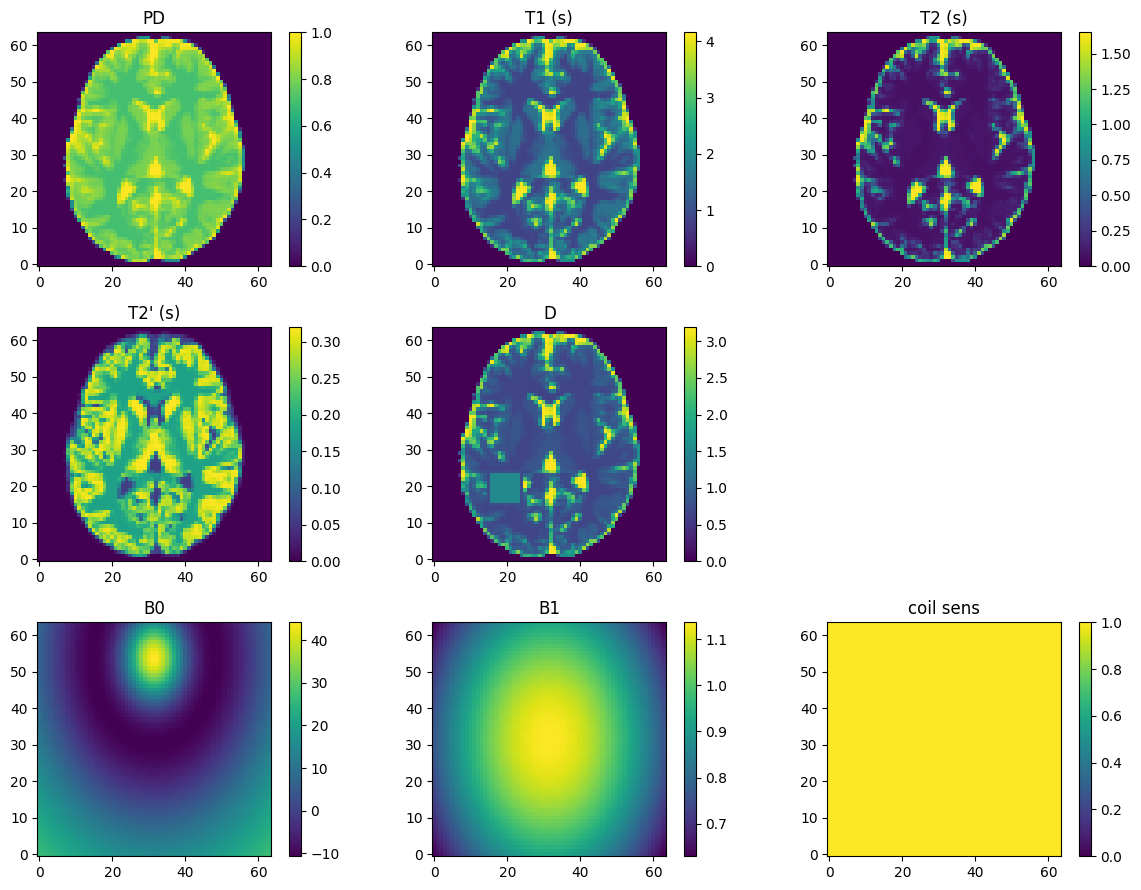

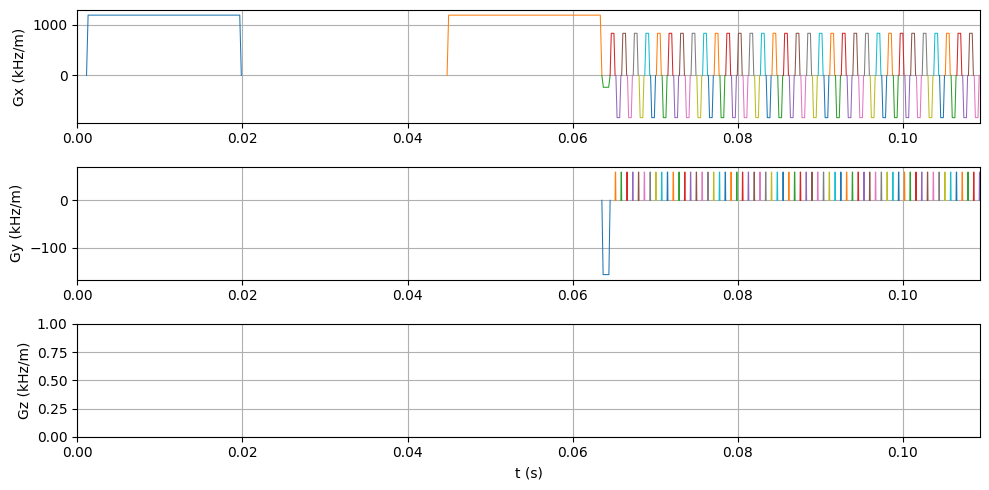

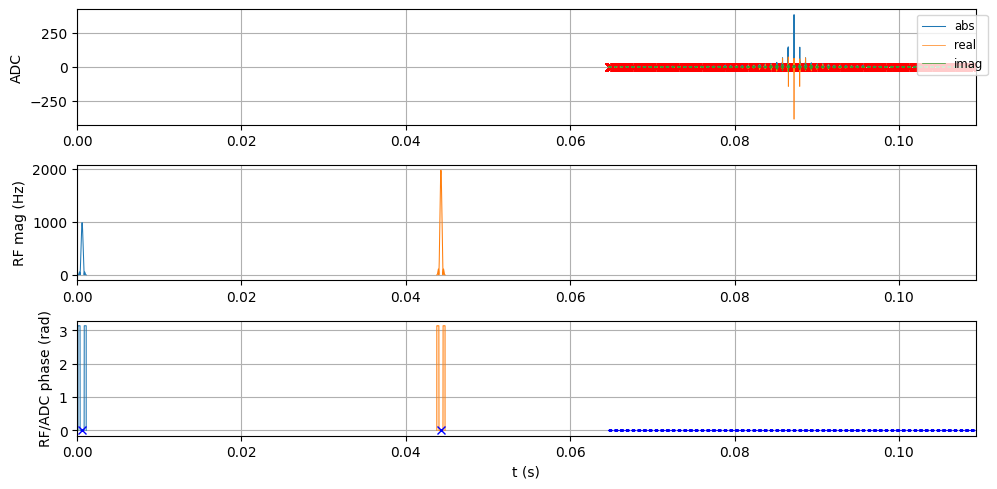

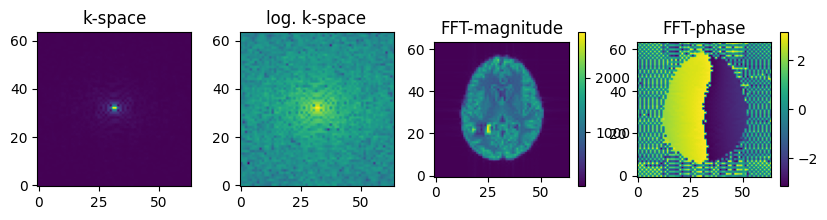

In [1]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

def seq_dwi_se_epi(
    fov=240e-3,
    slice_thickness=8e-3,
    sz=(64, 64),
    Nread=64,
    Nphase=64,
    G=1192028,
    Diff_grad_duration=18.75e-3,
    EPI_adc_duration_OG=0.25e-3,
    EPI_blip_duration=0.0001,
    eddy_currents=False,
    eddy_currents_induced_delay=0.0000015
):

    # %% S1. SETUP sys

    # choose the scanner limits
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=10e-6
    )

    # %% S2. DEFINE the sequence
    seq = pp.Sequence(system)

    # ===========================
    #     Diffusion elements
    # ===========================
    rf90, gz90, gz90_re = pp.make_sinc_pulse(
        flip_angle=90 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    rf180, gz180, gz180_re = pp.make_sinc_pulse(
        flip_angle=180 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )

    gx_diff = pp.make_trapezoid(channel='x', amplitude=G, duration=Diff_grad_duration, system=system)

    # ===========================
    #       Readout elements
    # ===========================
    # Define other gradients and ADC events
    a = int(system.adc_raster_time * Nread * 10**7)
    b = int(system.grad_raster_time * 10**7)
    c = int(EPI_adc_duration_OG * 10**7)
    lcm_ab = abs(a * b) // np.gcd(a, b)
    adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7


    eddy_currents_induced_delay*=eddy_currents

    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
    gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
    gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=EPI_blip_duration, system=system)

    # ============================================
    #     Delay for TE(180) = mid. EPI readout
    # ============================================
    TE_EPI = rf180.shape_dur/2. + rf180.ringdown_time + pp.calc_duration(gx_diff) + pp.calc_duration(gx_pre) + pp.calc_duration(gx) * (Nread/2 + 1 + 1./2.) + pp.calc_duration(gp_blip) * (Nread/2 + 1)
    print("TE_EPI = ", TE_EPI)

    TE_Diff_temp = rf90.shape_dur/2 + rf90.ringdown_time + pp.calc_duration(gx_diff) + rf180.delay + rf180.shape_dur/2
    print("TE_Diffusion_temp = ", TE_Diff_temp)

    delta_TE = TE_EPI - TE_Diff_temp
    delay = pp.make_delay(delta_TE)
    print("A delay of ", delta_TE, " is necessary")

    # ============================================
    #           b-value calculation
    # ============================================
    G_amp = gx_diff.amplitude
    delta =  pp.calc_duration(gx_diff)  # Gradient duration in seconds
    Delta = pp.calc_duration(gx_diff) +pp.calc_duration(rf180) + delta_TE # Time between gradients, assuming echo time is twice the gradient duration

    #b = γ² G² δ² (Δ−δ/3)
    b_value_pulseq_SI = (2*np.pi)** 2 * ((G_amp) ** 2) * (delta ** 2) * (Delta - (delta / 3))
    b_value_pulseq=b_value_pulseq_SI  *1e-6        # m^-2 to mm^-2
    print(f"Calculated b-value: {b_value_pulseq:.2f} s/mm^2")

    # ============================================
    #          Construct sequence
    # ============================================

    # Diffusion preparation
    seq.add_block(rf90)
    seq.add_block(gx_diff)
    seq.add_block(delay)
    seq.add_block(rf180)
    seq.add_block(gx_diff)
    '''
    seq.add_block(rf90, gz90)
    seq.add_block(gz90_re, gx_diff)
    seq.add_block(delay)
    seq.add_block(rf180, gz180)
    seq.add_block(gz180_re, gx_diff)
    '''

    # GRE EPI Readout
    gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)

    for ii in range(0, Nphase//2):
        seq.add_block(gx,adc)
        seq.add_block(gp_blip)
        seq.add_block(gx_,adc)
        seq.add_block(gp_blip)

    # Return the sequence object
    return seq


# Define parameters using Colab's form fields
fov = 240e-3 #@param {type:"number"}
slice_thickness = 8e-3 #@param {type:"number"}
Nread = 64 #@param {type:"integer"}
Nphase = 64 #@param {type:"integer"}
G = 1192028 #@param {type:"integer"}
Diff_grad_duration = 18.75e-3 #@param {type:"number"}
EPI_adc_duration_OG = 0.25e-3 #@param {type:"number"}
EPI_blip_duration = 0.0001 #@param {type:"number"}
eddy_currents = False #@param {type:"boolean"}
eddy_currents_induced_delay = 0.0000015 #@param {type:"number"}


# Call the sequence generation function
seq = seq_dwi_se_epi(
    fov=fov,
    slice_thickness=slice_thickness,
    sz=(Nread, Nphase), # Assuming sz is based on Nread and Nphase
    Nread=Nread,
    Nphase=Nphase,
    G=G,
    Diff_grad_duration=Diff_grad_duration,
    EPI_adc_duration_OG=EPI_adc_duration_OG,
    EPI_blip_duration=EPI_blip_duration,
    eddy_currents=eddy_currents,
    eddy_currents_induced_delay=eddy_currents_induced_delay
)

# ============================================
#               Export sequence
# ============================================

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq_write_signature = seq.write(experiment_id + '.seq')


# ============================================
#                 Simulate
# ============================================
sz = [Nread, Nphase] # Use Nread and Nphase for simulation size
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.brainweb('subject05.npz')
obj_p = obj_p.interpolate(sz[0], sz[1], 32).slices([15])
obj_p.size[2]=0.08
# (ii) insert rectangular "Tumor"
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
# mr0 uses D in units of 10^-3 * mm ^2/s  this is the same as µm^2/ms

obj_p.D*=1
if 1:
    # construct tumor border region
    for ii in range(15, 25):
        for jj in range(15, 25):
            obj_p.D[ii, jj] = torch.tensor(0.75)

    # construct tumor filling
    for ii in range(16, 24):
        for jj in range(16, 24):
            obj_p.D[ii, jj] = torch.tensor(1.5)

# Store PD and B0 for comparison
D = obj_p.D
B0 = obj_p.B0
D=obj_p.D
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
graph = mr0.compute_graph(seq0, obj_p, 2000, 1e-4)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


# ============================================
#               Plot results
# ============================================
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,1::2] = torch.flip(kspace[:,1::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()